In [2]:
library(CausalImpact)
library(tidyverse)

Loading required package: bsts

Loading required package: BoomSpikeSlab

Loading required package: Boom


Attaching package: ‘Boom’


The following object is masked from ‘package:stats’:

    rWishart



Attaching package: ‘BoomSpikeSlab’


The following object is masked from ‘package:stats’:

    knots


Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: xts


Attaching package: ‘bsts’


The following object is masked from ‘package:BoomSpikeSlab’:

    SuggestBurn


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::first()  masks

## Graphing setup

In [3]:
## This will give roughly a 16:10 aspect ratio, with the height bumped up a little
options(repr.plot.width = 11.2, repr.plot.height = 8, repr.plot.res = 300)

si_number_scale <- scales::label_number(scale_cut=scales::cut_si(""))

facet_rename <- as_labeller(c(
    "original" = "actual and synthetic control",
    "pointwise" = "estimated monthly impact",
    "cumulative" = "estimated cumulative impact"
))

plot_model <- function(model) {
    plot(model) +
        scale_x_datetime(expand = c(0, 0)) +
        scale_y_continuous(
            labels = si_number_scale,
            name = "Monthly unique devices underestimate"
        ) +
        facet_wrap(
            vars(metric),
            scales="free",
            ncol=1,
            labeller=facet_rename
        )
}

## Data wrangling

Here we are gathering monthly unique devices data for every country. Notably:
* we are using the uniques _underestimate_, which is a subset of unique devices excluding those which only had a one-action session without cookies. This will exclude most bots, likely making for less noisy data, at the cost of underestimating the true value. Since we are try to understand the marginal impact from switching data centers, this should still give us an estimated impact which we can validly apply to regular unique devices data.
* we are using the unique devices data for the top single wiki in each country. This is because the unique devices per project (wiki) data starts in 2016-01, while the unique device per project family data starts in 2017-04. We are most interested in the latter, but that does not give us enough history before the Eqsin switch for a reliable analysis. Luckily, if we look at unique devices for the top wiki in each country, we can get an extra 15 months of history while the trend and marginal impact of the new data center should still be the same.

In [6]:
top_wiki_ud <- arrow::read_parquet("../data/top_wiki_ud_per_country.parquet")

switches <- readr::read_tsv(
    "../reference/data_center_switches.tsv", 
    col_types = "fDff",
    # Useful when working with country codes, because Namibia has the code "NA"
    na = c("")
)

I will model each of the cohorts switching to Eqsin separately.

In [10]:
cohort_1 <-
    switches |>
    filter(cohort == "eqsin_1") |>
    pull(country) |>
    as.character()

cohort_2 <-
    switches |>
    filter(cohort == "eqsin_2") |>
    pull(country) |>
    as.character()

Six of the eight WMF regions had no countries switching to Eqsin. I use those regions as controls.

In [19]:
control_regions = c(
    "Central & Eastern Europe & Central Asia",
    "Northern & Western Europe",
    "Latin America & Caribbean",
    "Middle East & North Africa",
    "North America",
    "Sub-Saharan Africa"
)

control_uniques <-
    top_wiki_ud |>
    filter(wikimedia_region %in% control_regions) |>
    group_by(wikimedia_region, time) |>
    summarize(uniques_underestimate = sum(uniques_underestimate)) |>
    pivot_wider(names_from = wikimedia_region, values_from = uniques_underestimate)

`summarise()` has grouped output by 'wikimedia_region'. You can override using
the `.groups` argument.


In [20]:
cohort_1_uniques <-
    top_wiki_ud |>
    filter(country %in% cohort_1) |>
    group_by(time) |>
    summarize(cohort_1 = sum(uniques_underestimate)) |>
    full_join(control_uniques)


cohort_1_pre_period <- ymd_hms(c("2016-01-01", "2018-03-01"), truncated = 3)
cohort_1_post_period <- ymd_hms(c("2018-04-01", "2019-03-01"), truncated = 3)


cohort_2_uniques <-
    top_wiki_ud |>
    filter(country %in% cohort_2) |>
    group_by(time) |>
    summarize(cohort_2 = sum(uniques_underestimate)) |>
    full_join(control_uniques)

cohort_2_pre_period <- ymd_hms(c("2016-01-01", "2018-07-01"), truncated = 3)
cohort_2_post_period <- ymd_hms(c("2018-08-01", "2019-07-01"), truncated = 3)

# CausalImpacts won't take input in Tibble format
to_zoo <- function(d) {
    zoo::zoo(d[, -1], d[["time"]])
}

cohort_1_uniques_zoo <- to_zoo(cohort_1_uniques)
cohort_2_uniques_zoo <- to_zoo(cohort_2_uniques)

Joining with `by = join_by(time)`
Joining with `by = join_by(time)`


## Cohort 1

### Default (no extra data, seasonality)

In [49]:
lsf.str("package:CausalImpact")

as.CausalImpact : function (x, ...)  
CausalImpact : function (data = NULL, pre.period = NULL, post.period = NULL, model.args = NULL, 
    bsts.model = NULL, post.period.response = NULL, alpha = 0.05)  

In [29]:
c1 <- CausalImpact(
    window(cohort_1_uniques_zoo, end = cohort_1_post_period[2]),
    cohort_1_pre_period,
    cohort_1_post_period,
    model.args = list(nseasons = 12, niter = 15000)
)

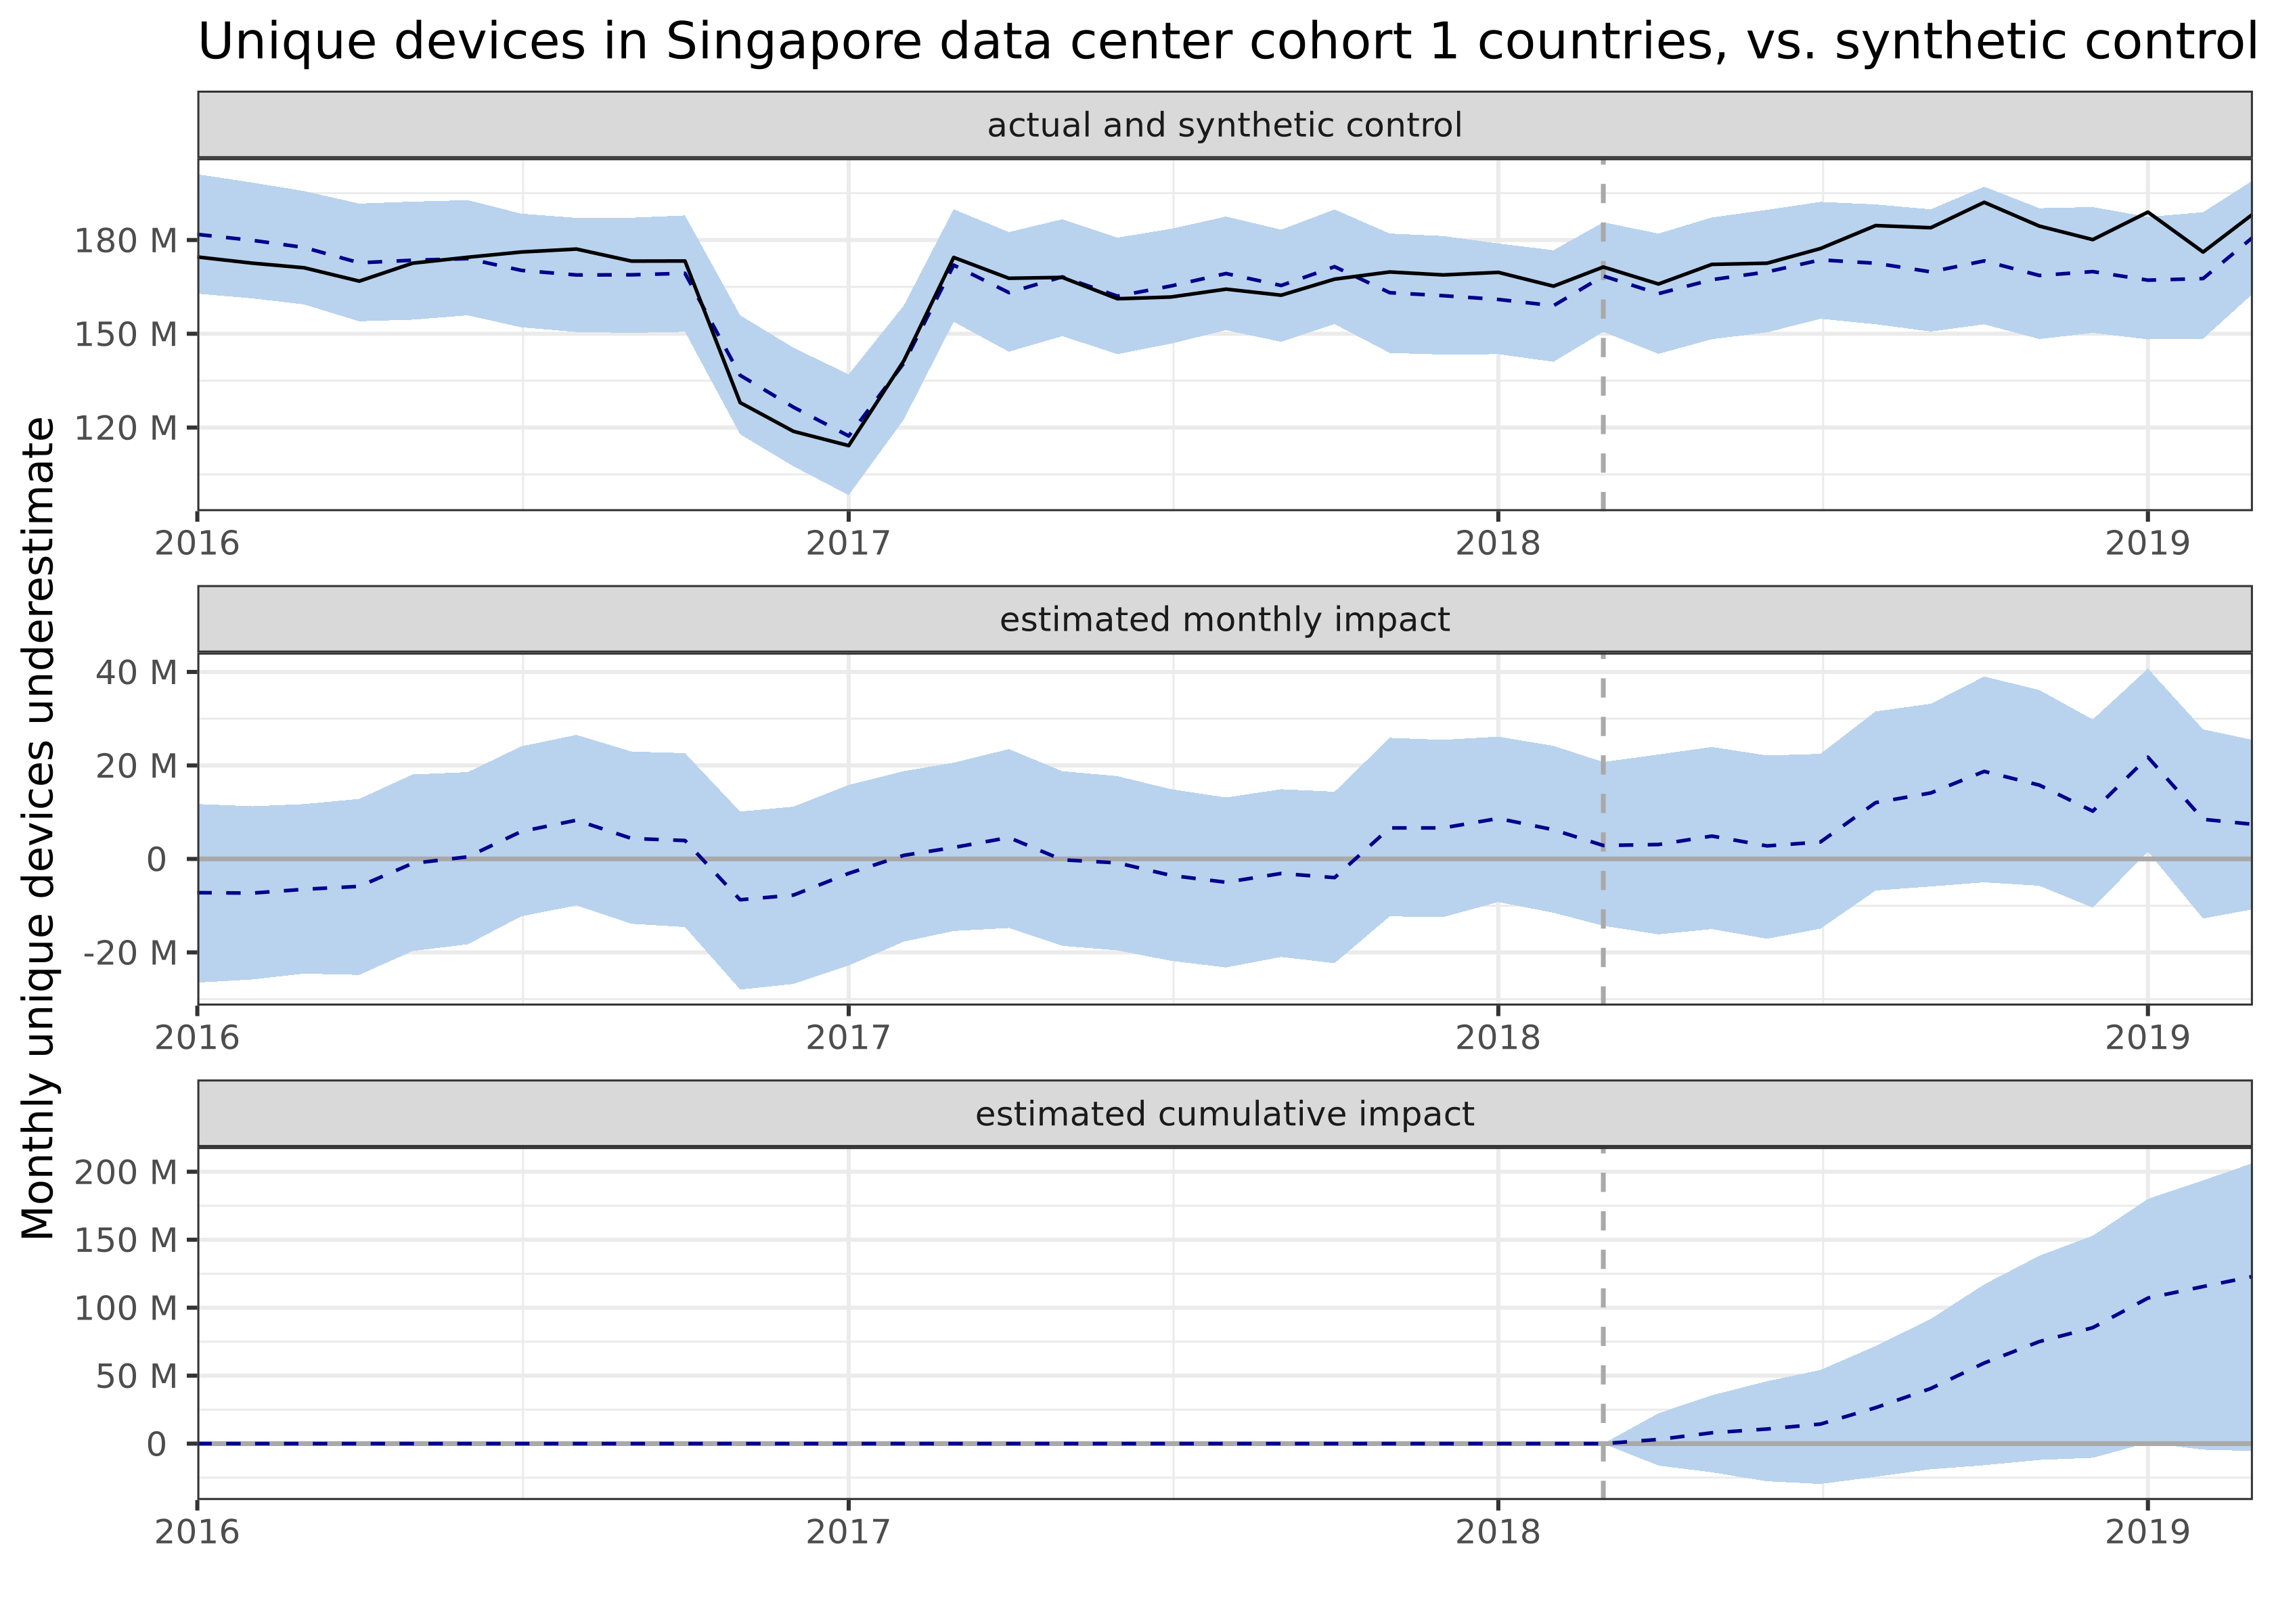

In [42]:
plot_model(c1) +
    ggtitle("Unique devices in Singapore data center cohort 1 countries, vs. synthetic control")

In [43]:
ggsave(
    "../figures/Singapore_cohort_1_synthetic_control.png",
    device = "png",
    path = "../figures",
    height = 8.68,
    width = 13.89
)

In [52]:
capture.output(summary(c1), file = "../figures/Singapore_cohort_1_synthetic_control_summary.txt")

summary(c1)

Posterior inference {CausalImpact}

                         Average              Cumulative         
Actual                   1.8e+08              2.2e+09            
Prediction (s.d.)        1.7e+08 (4.3e+06)    2.0e+09 (5.2e+07)  
95% CI                   [1.6e+08, 1.8e+08]   [2.0e+09, 2.2e+09] 
                                                                 
Absolute effect (s.d.)   1.0e+07 (4.3e+06)    1.2e+08 (5.2e+07)  
95% CI                   [-450141, 1.7e+07]   [-5401694, 2.1e+08]
                                                                 
Relative effect (s.d.)   6.1% (2.6%)          6.1% (2.6%)        
95% CI                   [-0.25%, 11%]        [-0.25%, 11%]      

Posterior tail-area probability p:   0.02888
Posterior prob. of a causal effect:  97.112%

For more details, type: summary(impact, "report")



In the chart, the color of the bar refers to the coefficient on the regressor, in cases where it is not zero. White means a negative coefficient, grey means the coefficient can be either positive or negative, and black means the coefficient is positive.

png 
  2

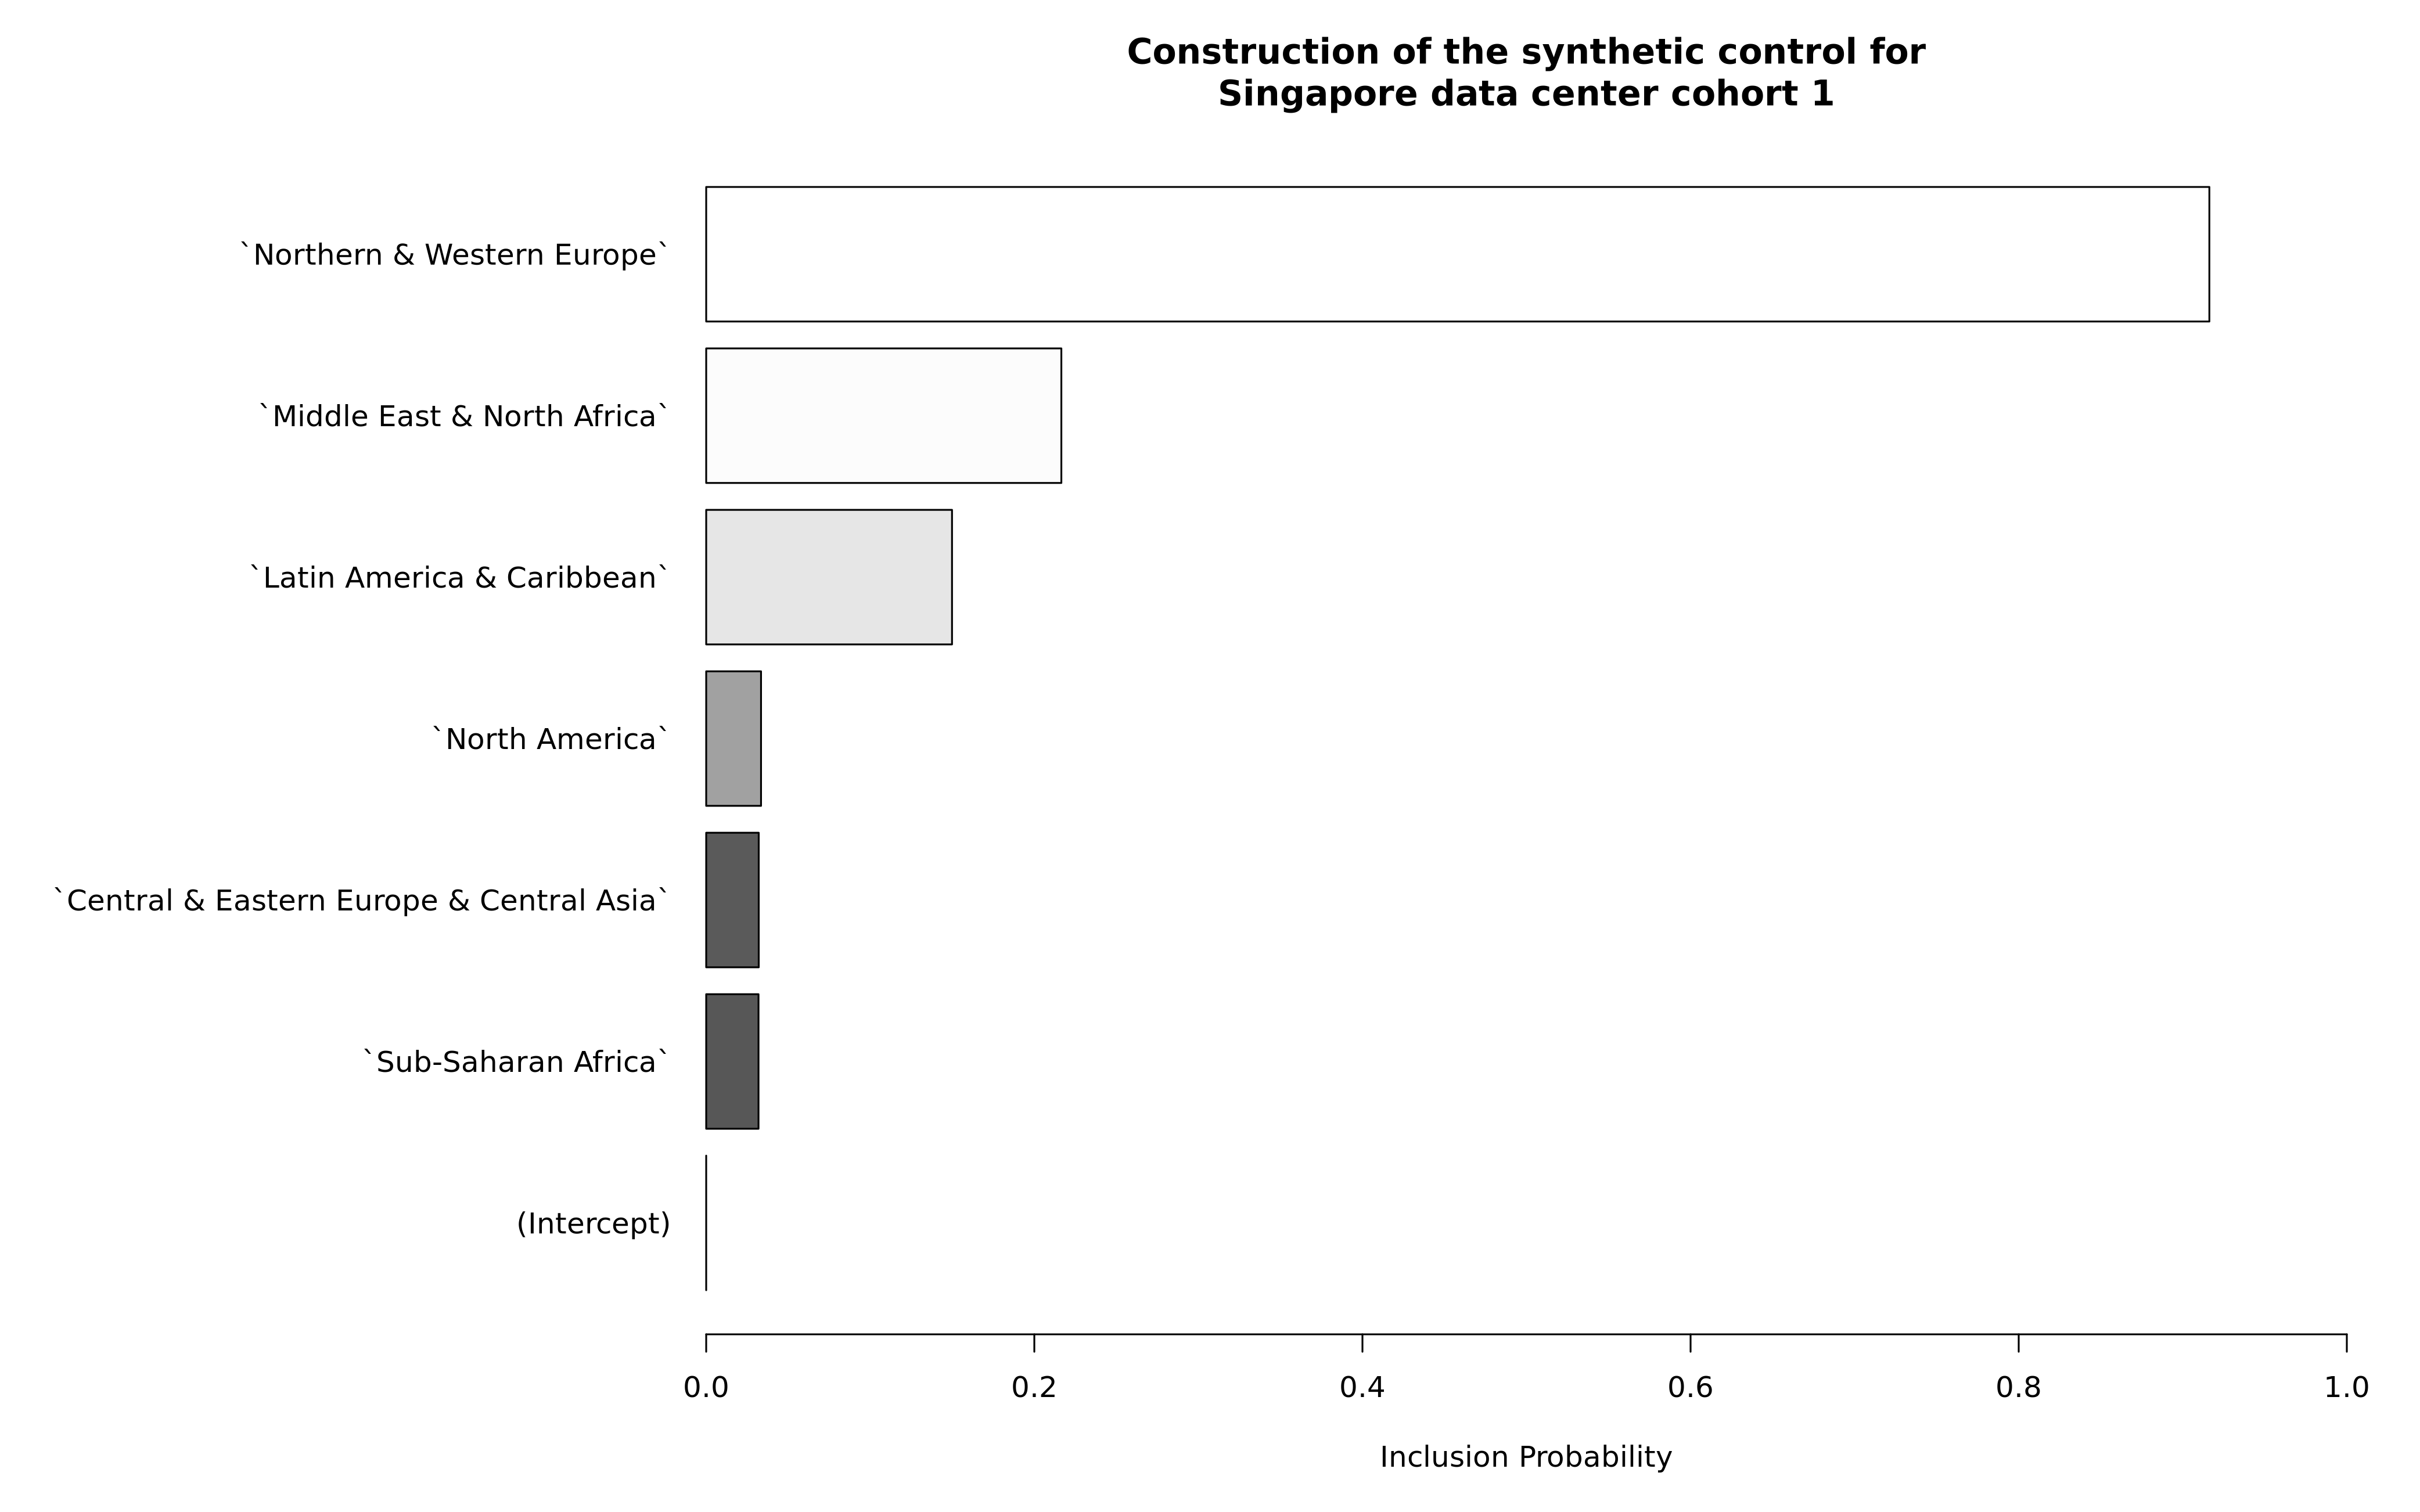

In [69]:
FILE_NAME = "../figures/Singapore_cohort_1_synthetical_control_coefficient_plot.png"

png(
    FILE_NAME,
    res = 300,
    height = 2604,
    width = 4167
)

plot(
    c1$model$bsts.model,
    "coefficients",
    main = "Construction of the synthetic control for\nSingapore data center cohort 1"
)

dev.off()

IRdisplay::display_png(file = FILE_NAME)

### Scaled data

Occasionally, modelling processes are sensitive to the magnitude of the data, so here I try scaling the data so that the numbers represent millions.

In [64]:
cohort_1_uniques_M <- cohort_1_uniques_zoo / 1000000

c1_s <- CausalImpact(
    window(cohort_1_uniques_M, end = cohort_1_post_period[2]),
    cohort_1_pre_period,
    cohort_1_post_period,
    model.args = list(nseasons = 12, niter = 15000)
)

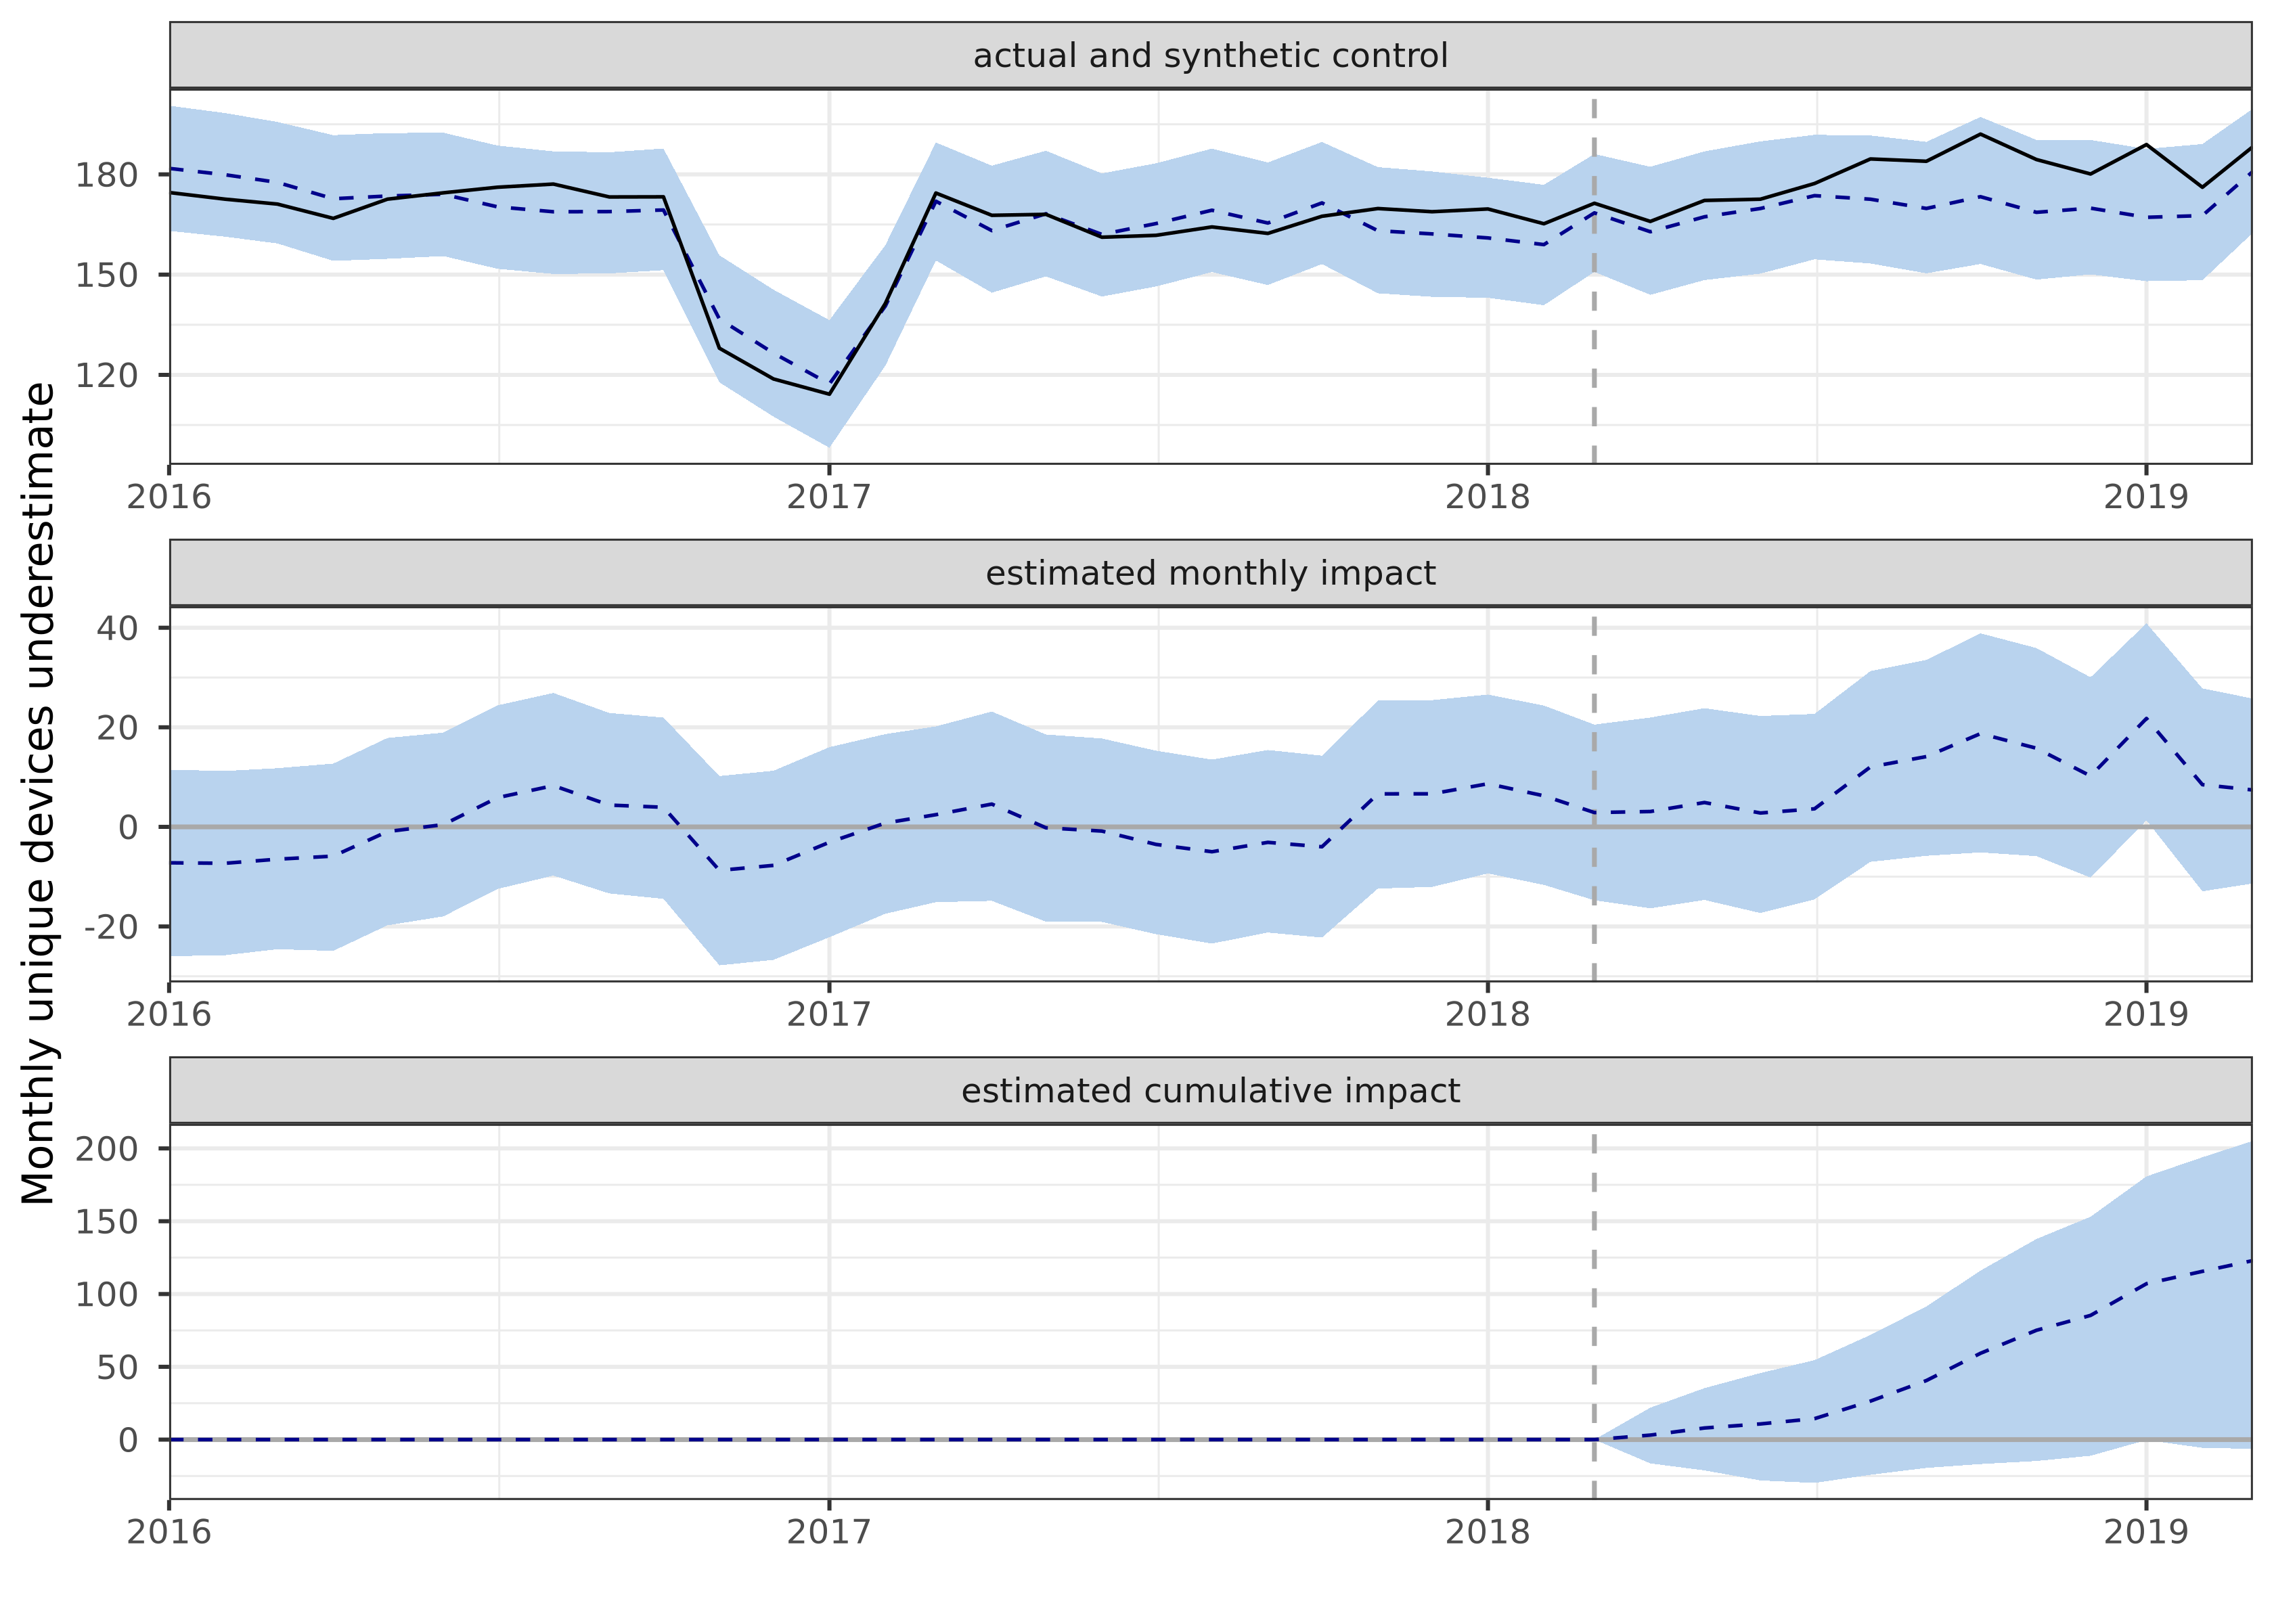

In [70]:
plot_model(c1_s)

There are some very minor differences (e.g. the 95% credible interval of the average effect is [-0.53 M, 17 M] here and [-0.45 M, 17 M] previously), but that's a normal result of the Monte Carlo method. The scaling doesn't seem to matter, which is nice.

In [72]:
summary(c1_s)

Posterior inference {CausalImpact}

                         Average         Cumulative   
Actual                   181             2166         
Prediction (s.d.)        170 (4.3)       2043 (52.0)  
95% CI                   [163, 181]      [1961, 2173] 
                                                      
Absolute effect (s.d.)   10 (4.3)        123 (52.0)   
95% CI                   [-0.53, 17]     [-6.34, 205] 
                                                      
Relative effect (s.d.)   6.1% (2.6%)     6.1% (2.6%)  
95% CI                   [-0.29%, 10%]   [-0.29%, 10%]

Posterior tail-area probability p:   0.03162
Posterior prob. of a causal effect:  96.838%

For more details, type: summary(impact, "report")



### Data after post period

We happen to have several years of data after the end of the post period (and initially, I ran the model without removing that data from the input). In several model runs (but not the one shown here), including that data seemed to produce a lower-confidence result (with roughly a 92% posterior probability of impact rather than 97%) It's not clear why this would happen, but it seems like some form of misbehavior, since CausalImpact should only be considering data from the specified pre and post periods.

In [79]:
c1_dap <- CausalImpact(
    cohort_1_uniques_zoo,
    cohort_1_pre_period,
    cohort_1_post_period,
    model.args = list(nseasons = 12, niter = 15000)
)

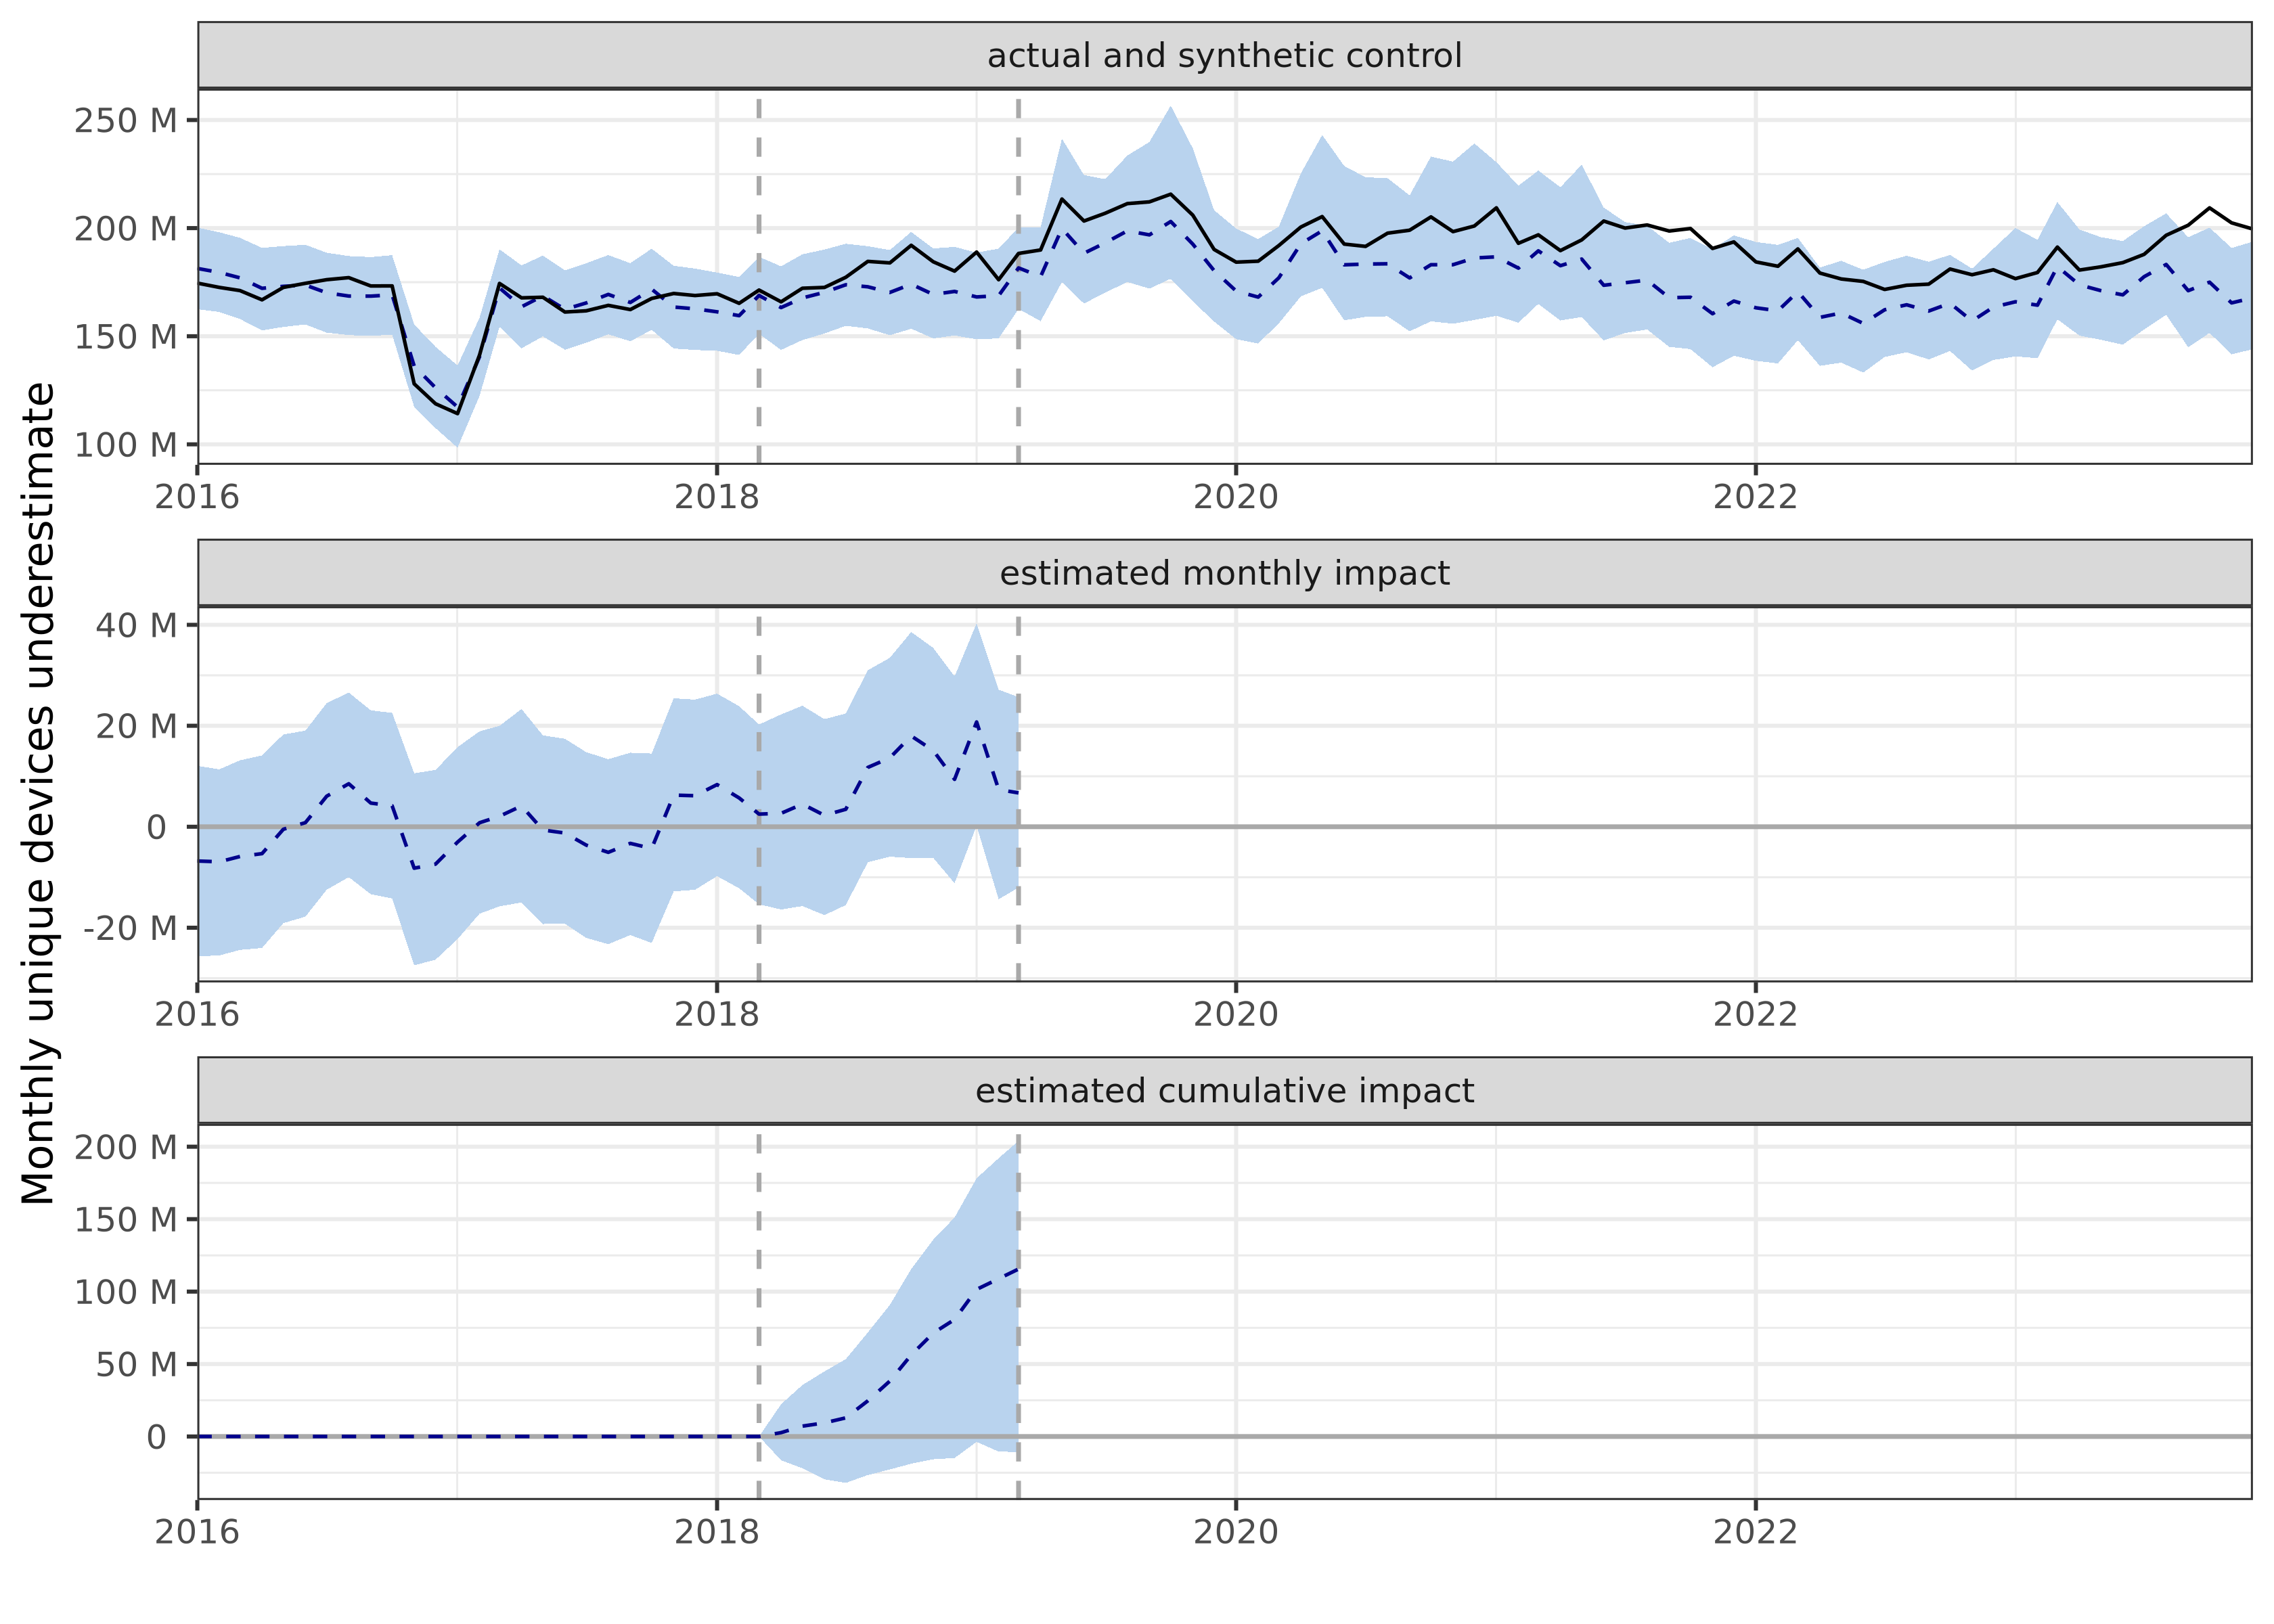

In [80]:
plot_model(c1_dap)

In [81]:
summary(c1_dap)

Posterior inference {CausalImpact}

                         Average               Cumulative         
Actual                   1.8e+08               2.2e+09            
Prediction (s.d.)        1.7e+08 (4.5e+06)     2.1e+09 (5.4e+07)  
95% CI                   [1.6e+08, 1.8e+08]    [2.0e+09, 2.2e+09] 
                                                                  
Absolute effect (s.d.)   9.6e+06 (4.5e+06)     1.2e+08 (5.4e+07)  
95% CI                   [-8.9e+05, 1.7e+07]   [-1.1e+07, 2.0e+08]
                                                                  
Relative effect (s.d.)   5.7% (2.7%)           5.7% (2.7%)        
95% CI                   [-0.49%, 10%]         [-0.49%, 10%]      

Posterior tail-area probability p:   0.036
Posterior prob. of a causal effect:  96.4%

For more details, type: summary(impact, "report")



### Data after post period, no seasonality

In [82]:
c1_dap_ns <- CausalImpact(
    cohort_1_uniques_zoo,
    cohort_1_pre_period,
    cohort_1_post_period,
    model.args = list(niter = 15000)
)

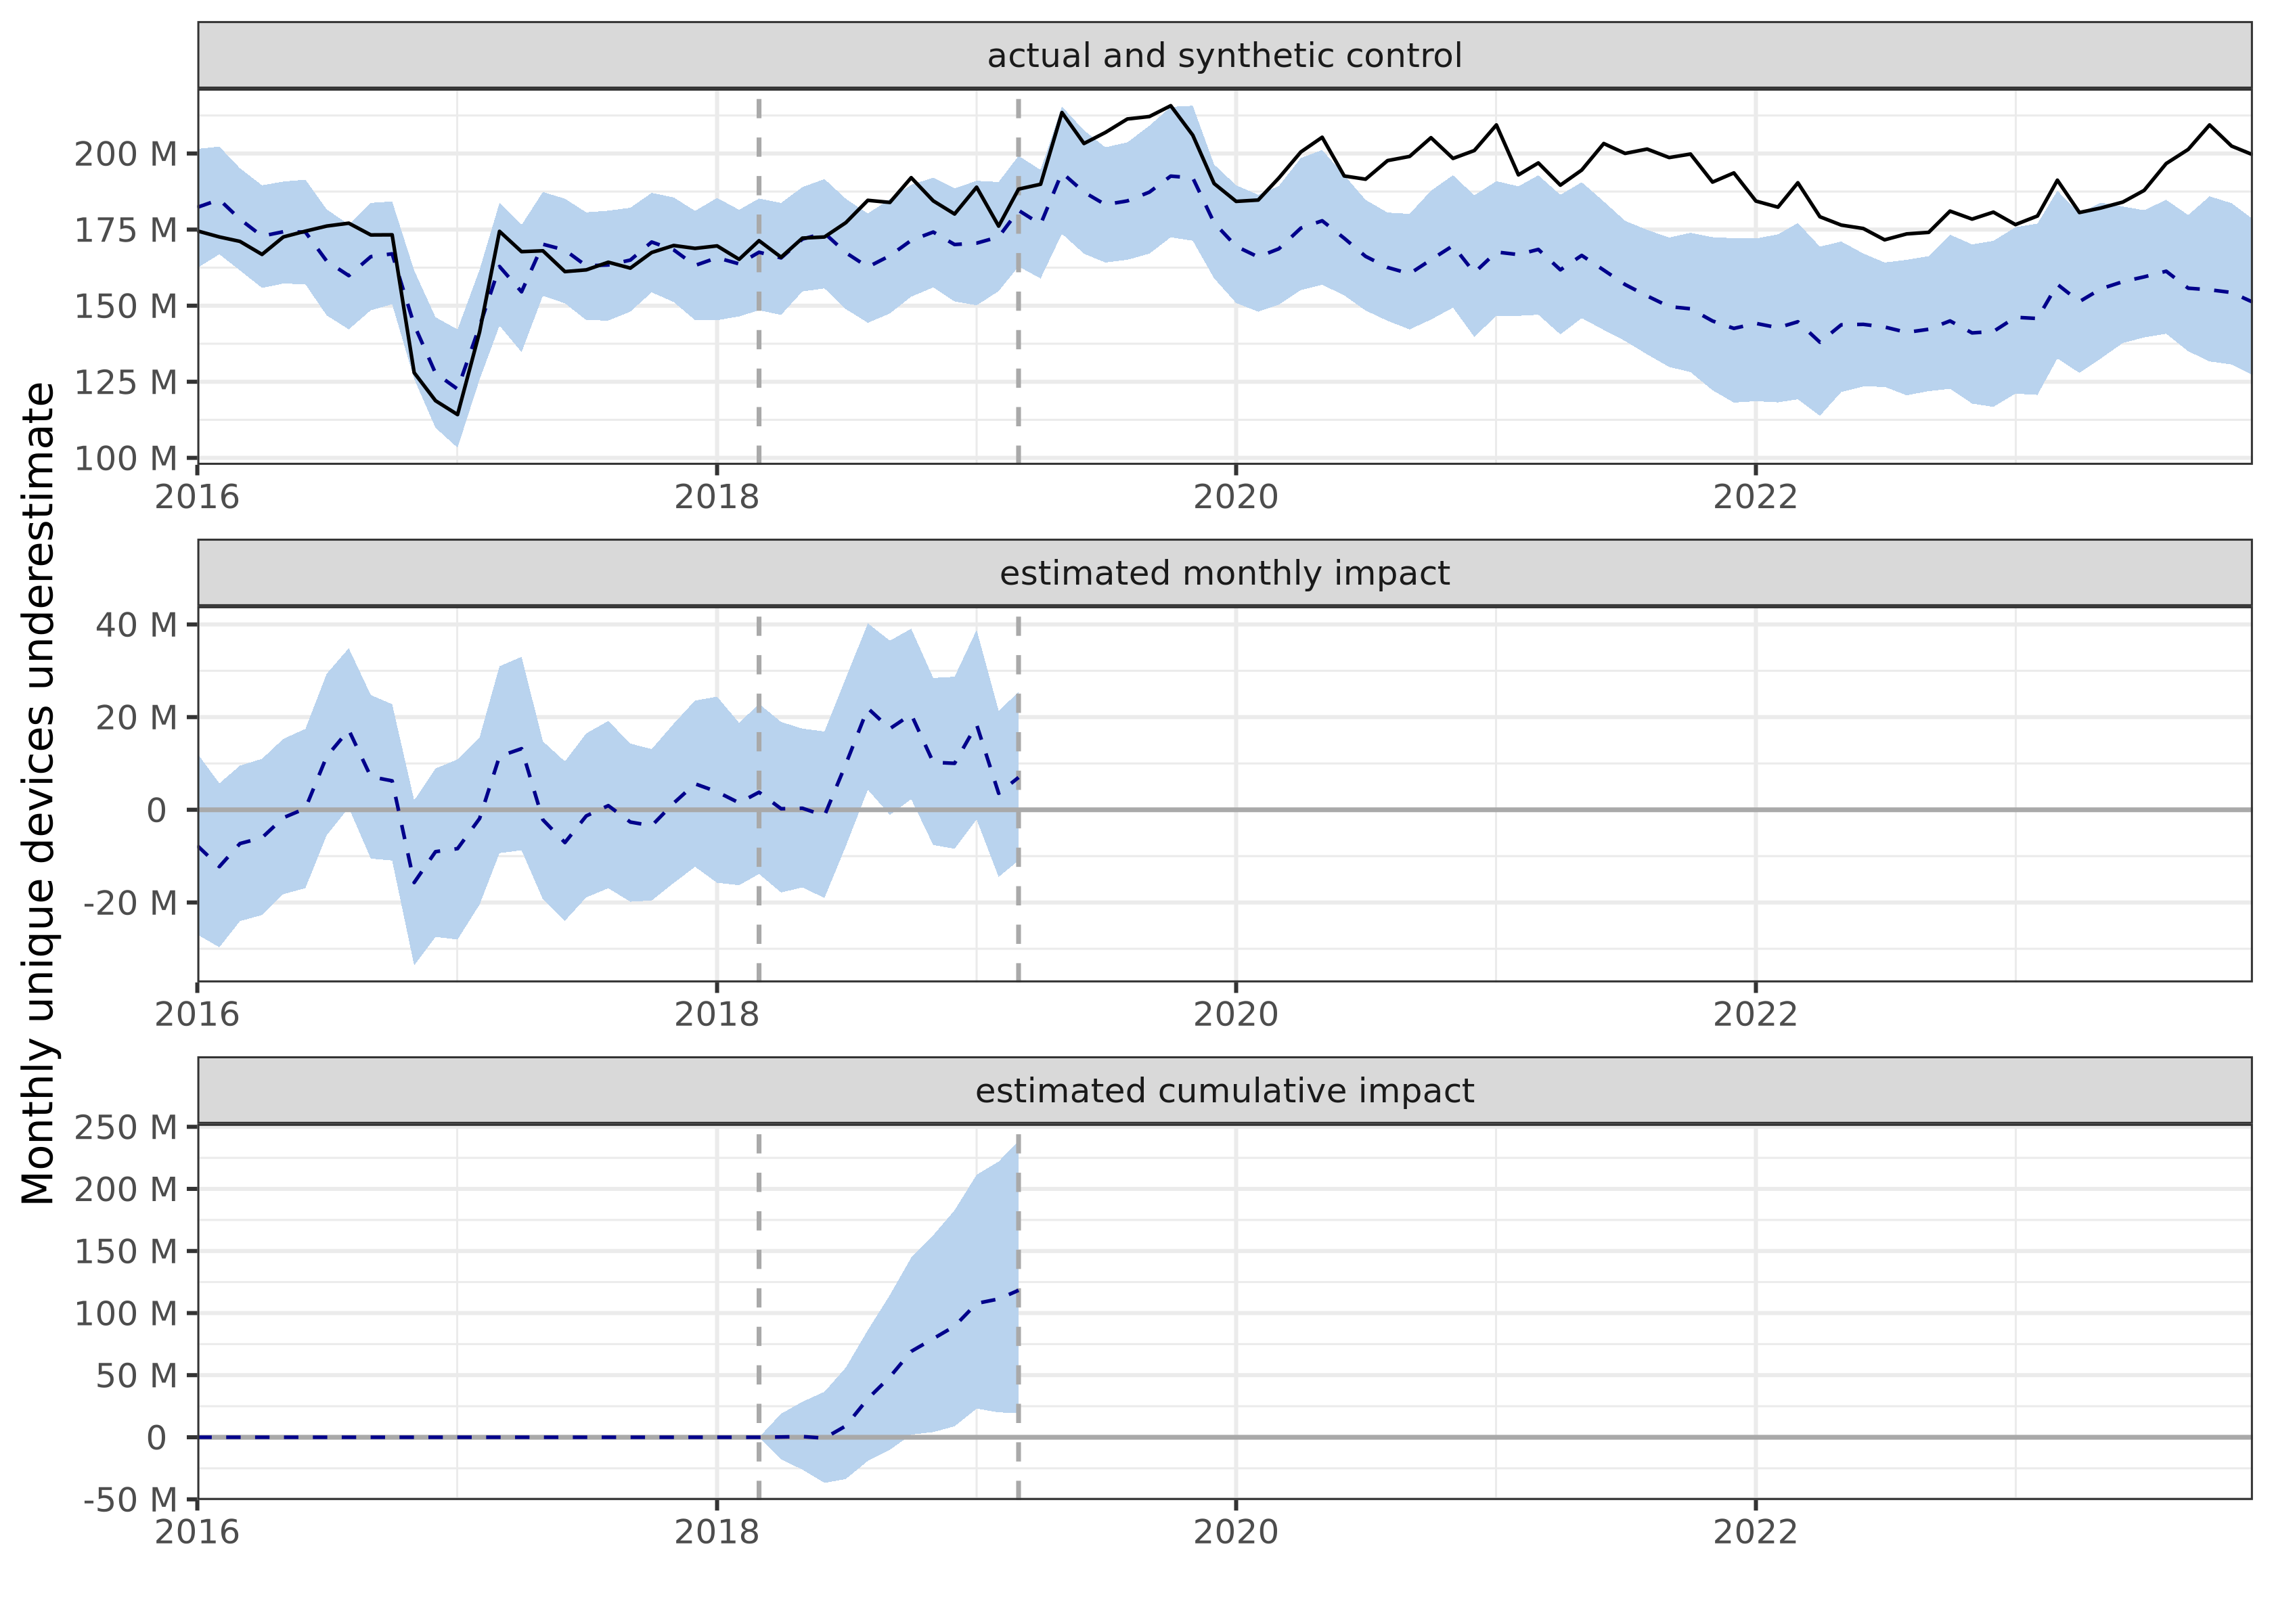

In [83]:
plot_model(c1_dap_ns)

In [84]:
summary(c1_dap_ns)

Posterior inference {CausalImpact}

                         Average              Cumulative        
Actual                   1.8e+08              2.2e+09           
Prediction (s.d.)        1.7e+08 (4.6e+06)    2.0e+09 (5.5e+07) 
95% CI                   [1.6e+08, 1.8e+08]   [1.9e+09, 2.1e+09]
                                                                
Absolute effect (s.d.)   9.9e+06 (4.6e+06)    1.2e+08 (5.5e+07) 
95% CI                   [1.6e+06, 2.0e+07]   [1.9e+07, 2.4e+08]
                                                                
Relative effect (s.d.)   5.9% (2.9%)          5.9% (2.9%)       
95% CI                   [0.91%, 12%]         [0.91%, 12%]      

Posterior tail-area probability p:   0.0104
Posterior prob. of a causal effect:  98.96%

For more details, type: summary(impact, "report")



### No seasonality

If we do not include seasonality in the model, confidence in the effect goes up substantially.

In [85]:
c1_ns <- CausalImpact(
    window(cohort_1_uniques_zoo, end = cohort_1_post_period[2]),
    cohort_1_pre_period,
    cohort_1_post_period,
    model.args = list(niter = 15000)
)

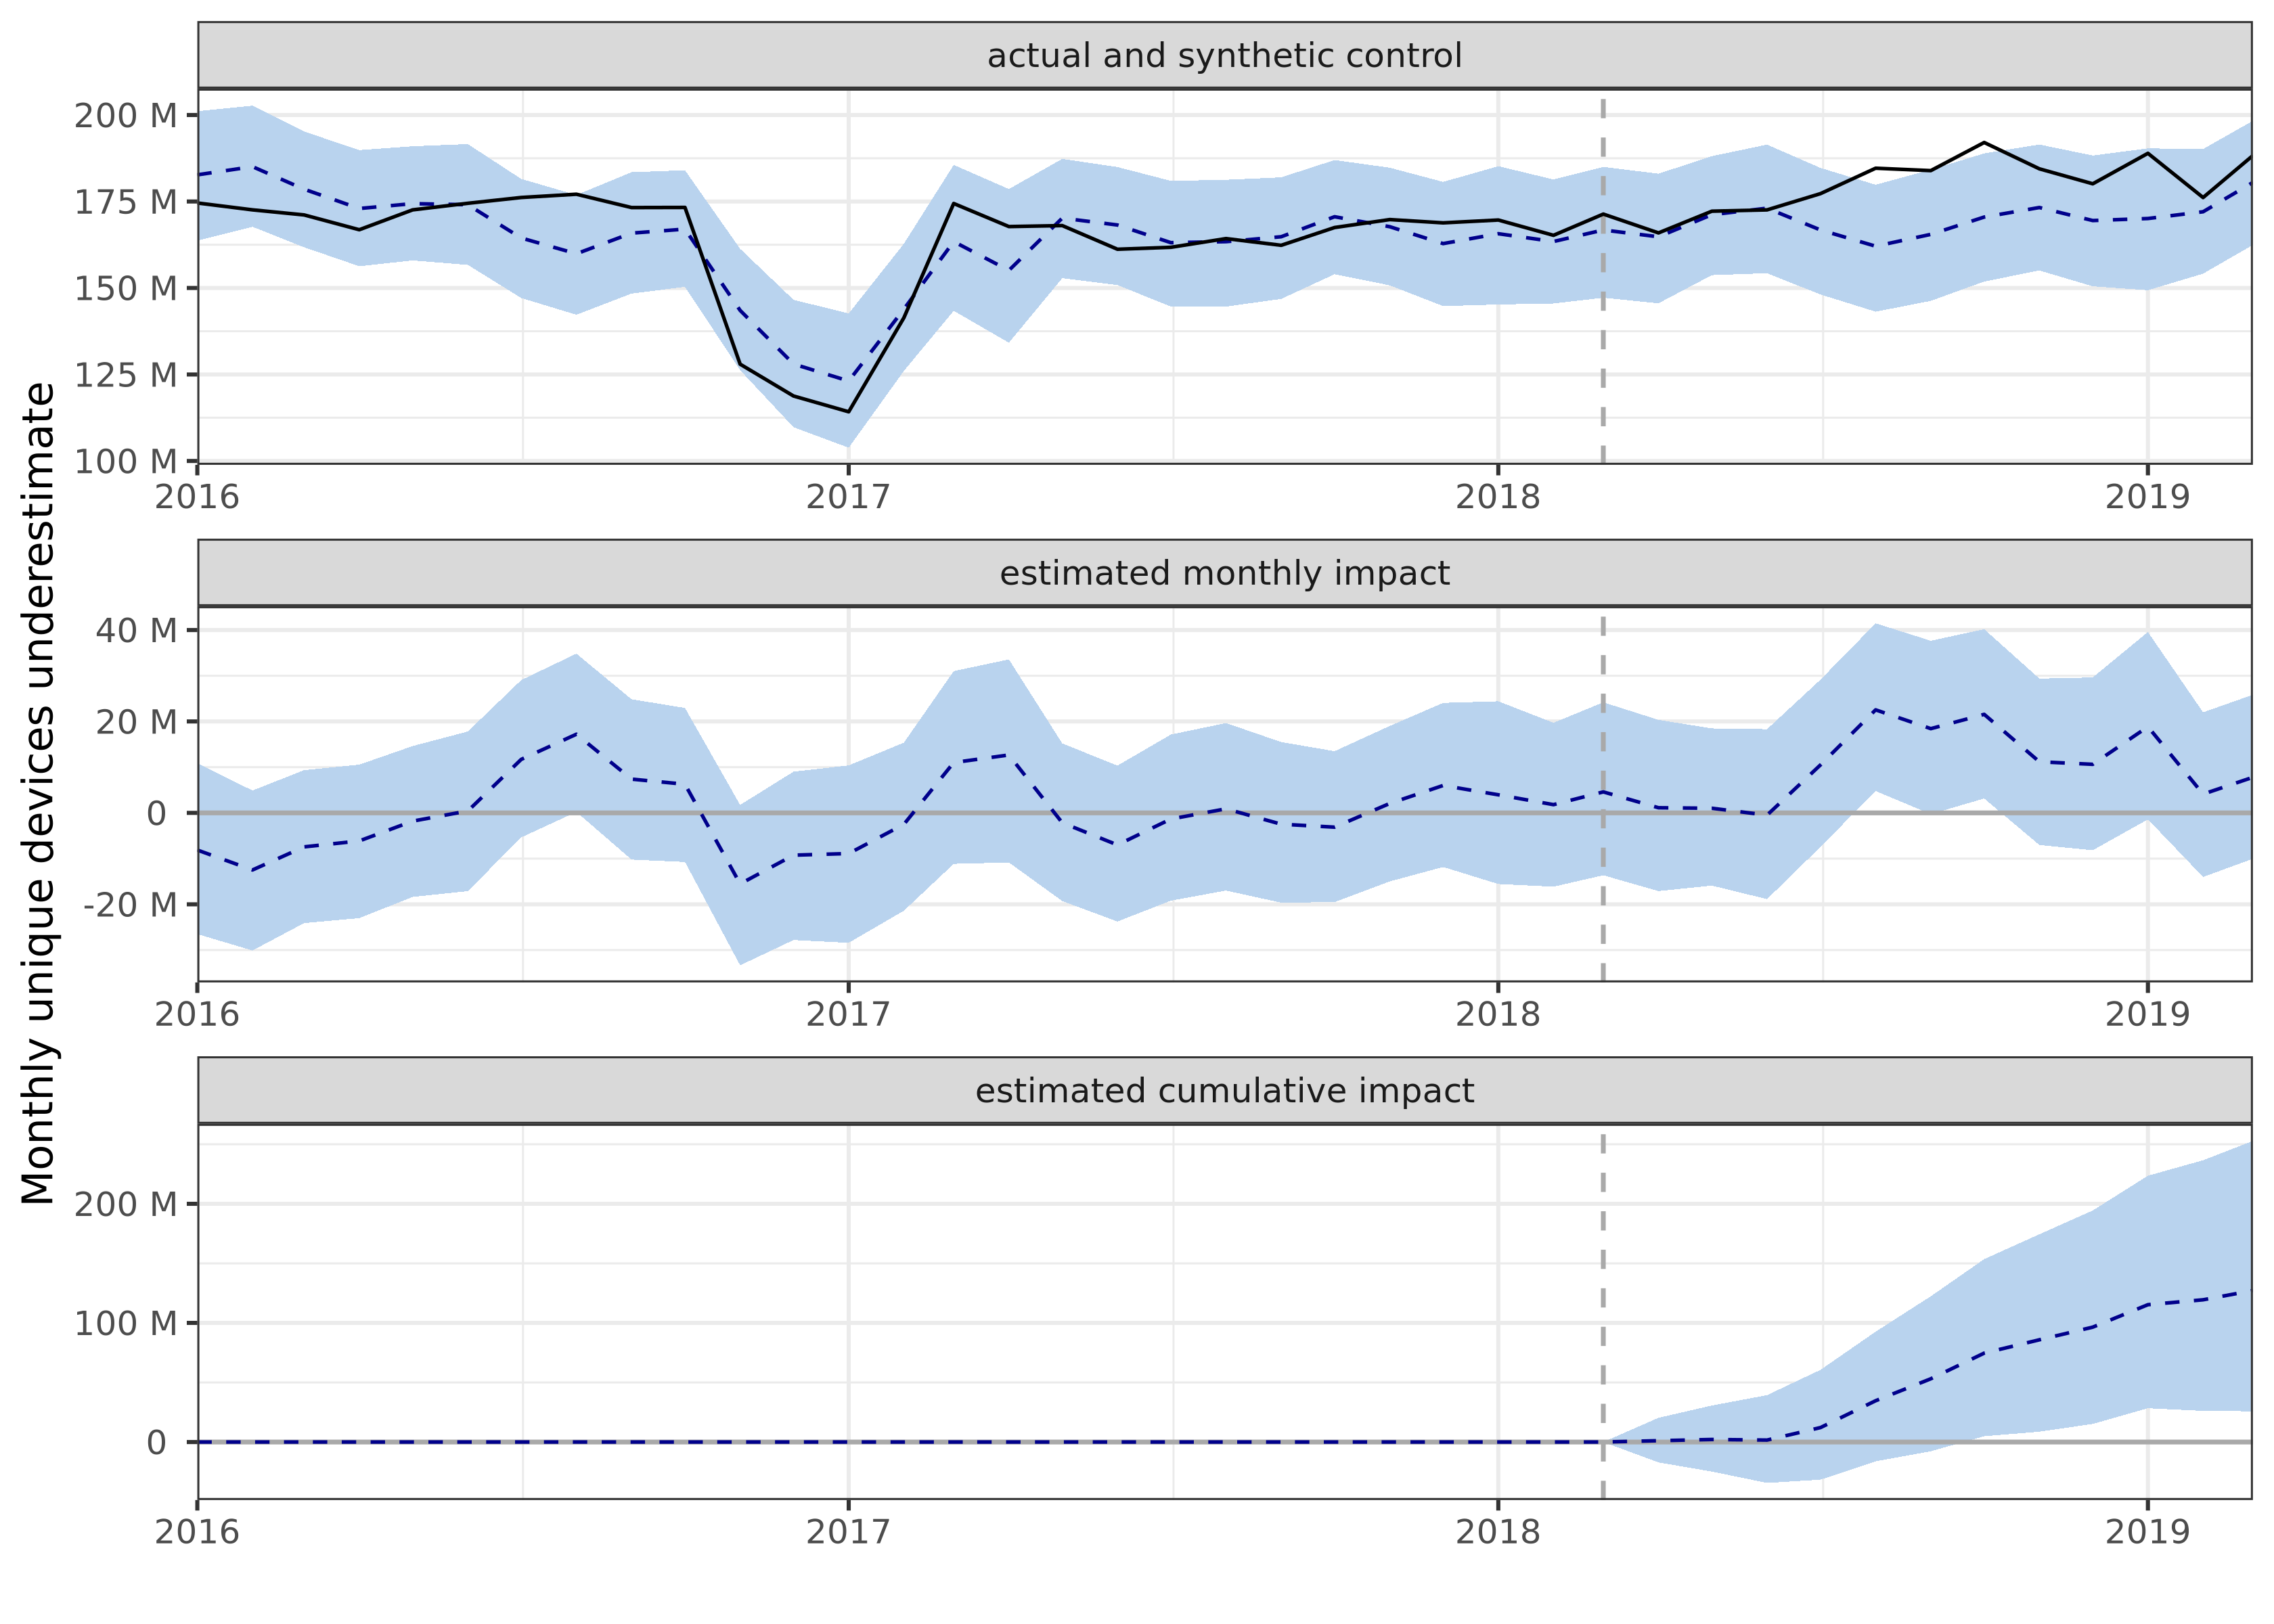

In [86]:
plot_model(c1_ns)

In [87]:
summary(c1_ns)

Posterior inference {CausalImpact}

                         Average              Cumulative        
Actual                   1.8e+08              2.2e+09           
Prediction (s.d.)        1.7e+08 (4.8e+06)    2.0e+09 (5.7e+07) 
95% CI                   [1.6e+08, 1.8e+08]   [1.9e+09, 2.1e+09]
                                                                
Absolute effect (s.d.)   1.1e+07 (4.8e+06)    1.3e+08 (5.7e+07) 
95% CI                   [2.2e+06, 2.1e+07]   [2.6e+07, 2.5e+08]
                                                                
Relative effect (s.d.)   6.3% (3%)            6.3% (3%)         
95% CI                   [1.2%, 13%]          [1.2%, 13%]       

Posterior tail-area probability p:   0.00568
Posterior prob. of a causal effect:  99.43216%

For more details, type: summary(impact, "report")



## Cohort 2

Since truncated data and seasonality seem like the most sensible paramater choices, we will only look at those for cohort 2. Nevertheless, the fact that all the different modeling choices for parameter 2 produced a robust positive result increases our confidence that Eqsin did have an effect on unique devices.

In [89]:
c2 <- CausalImpact(
    window(cohort_2_uniques_zoo, end = cohort_2_post_period[2]),
    cohort_2_pre_period,
    cohort_2_post_period,
    model.args = list(nseasons = 12, niter = 15000)
)

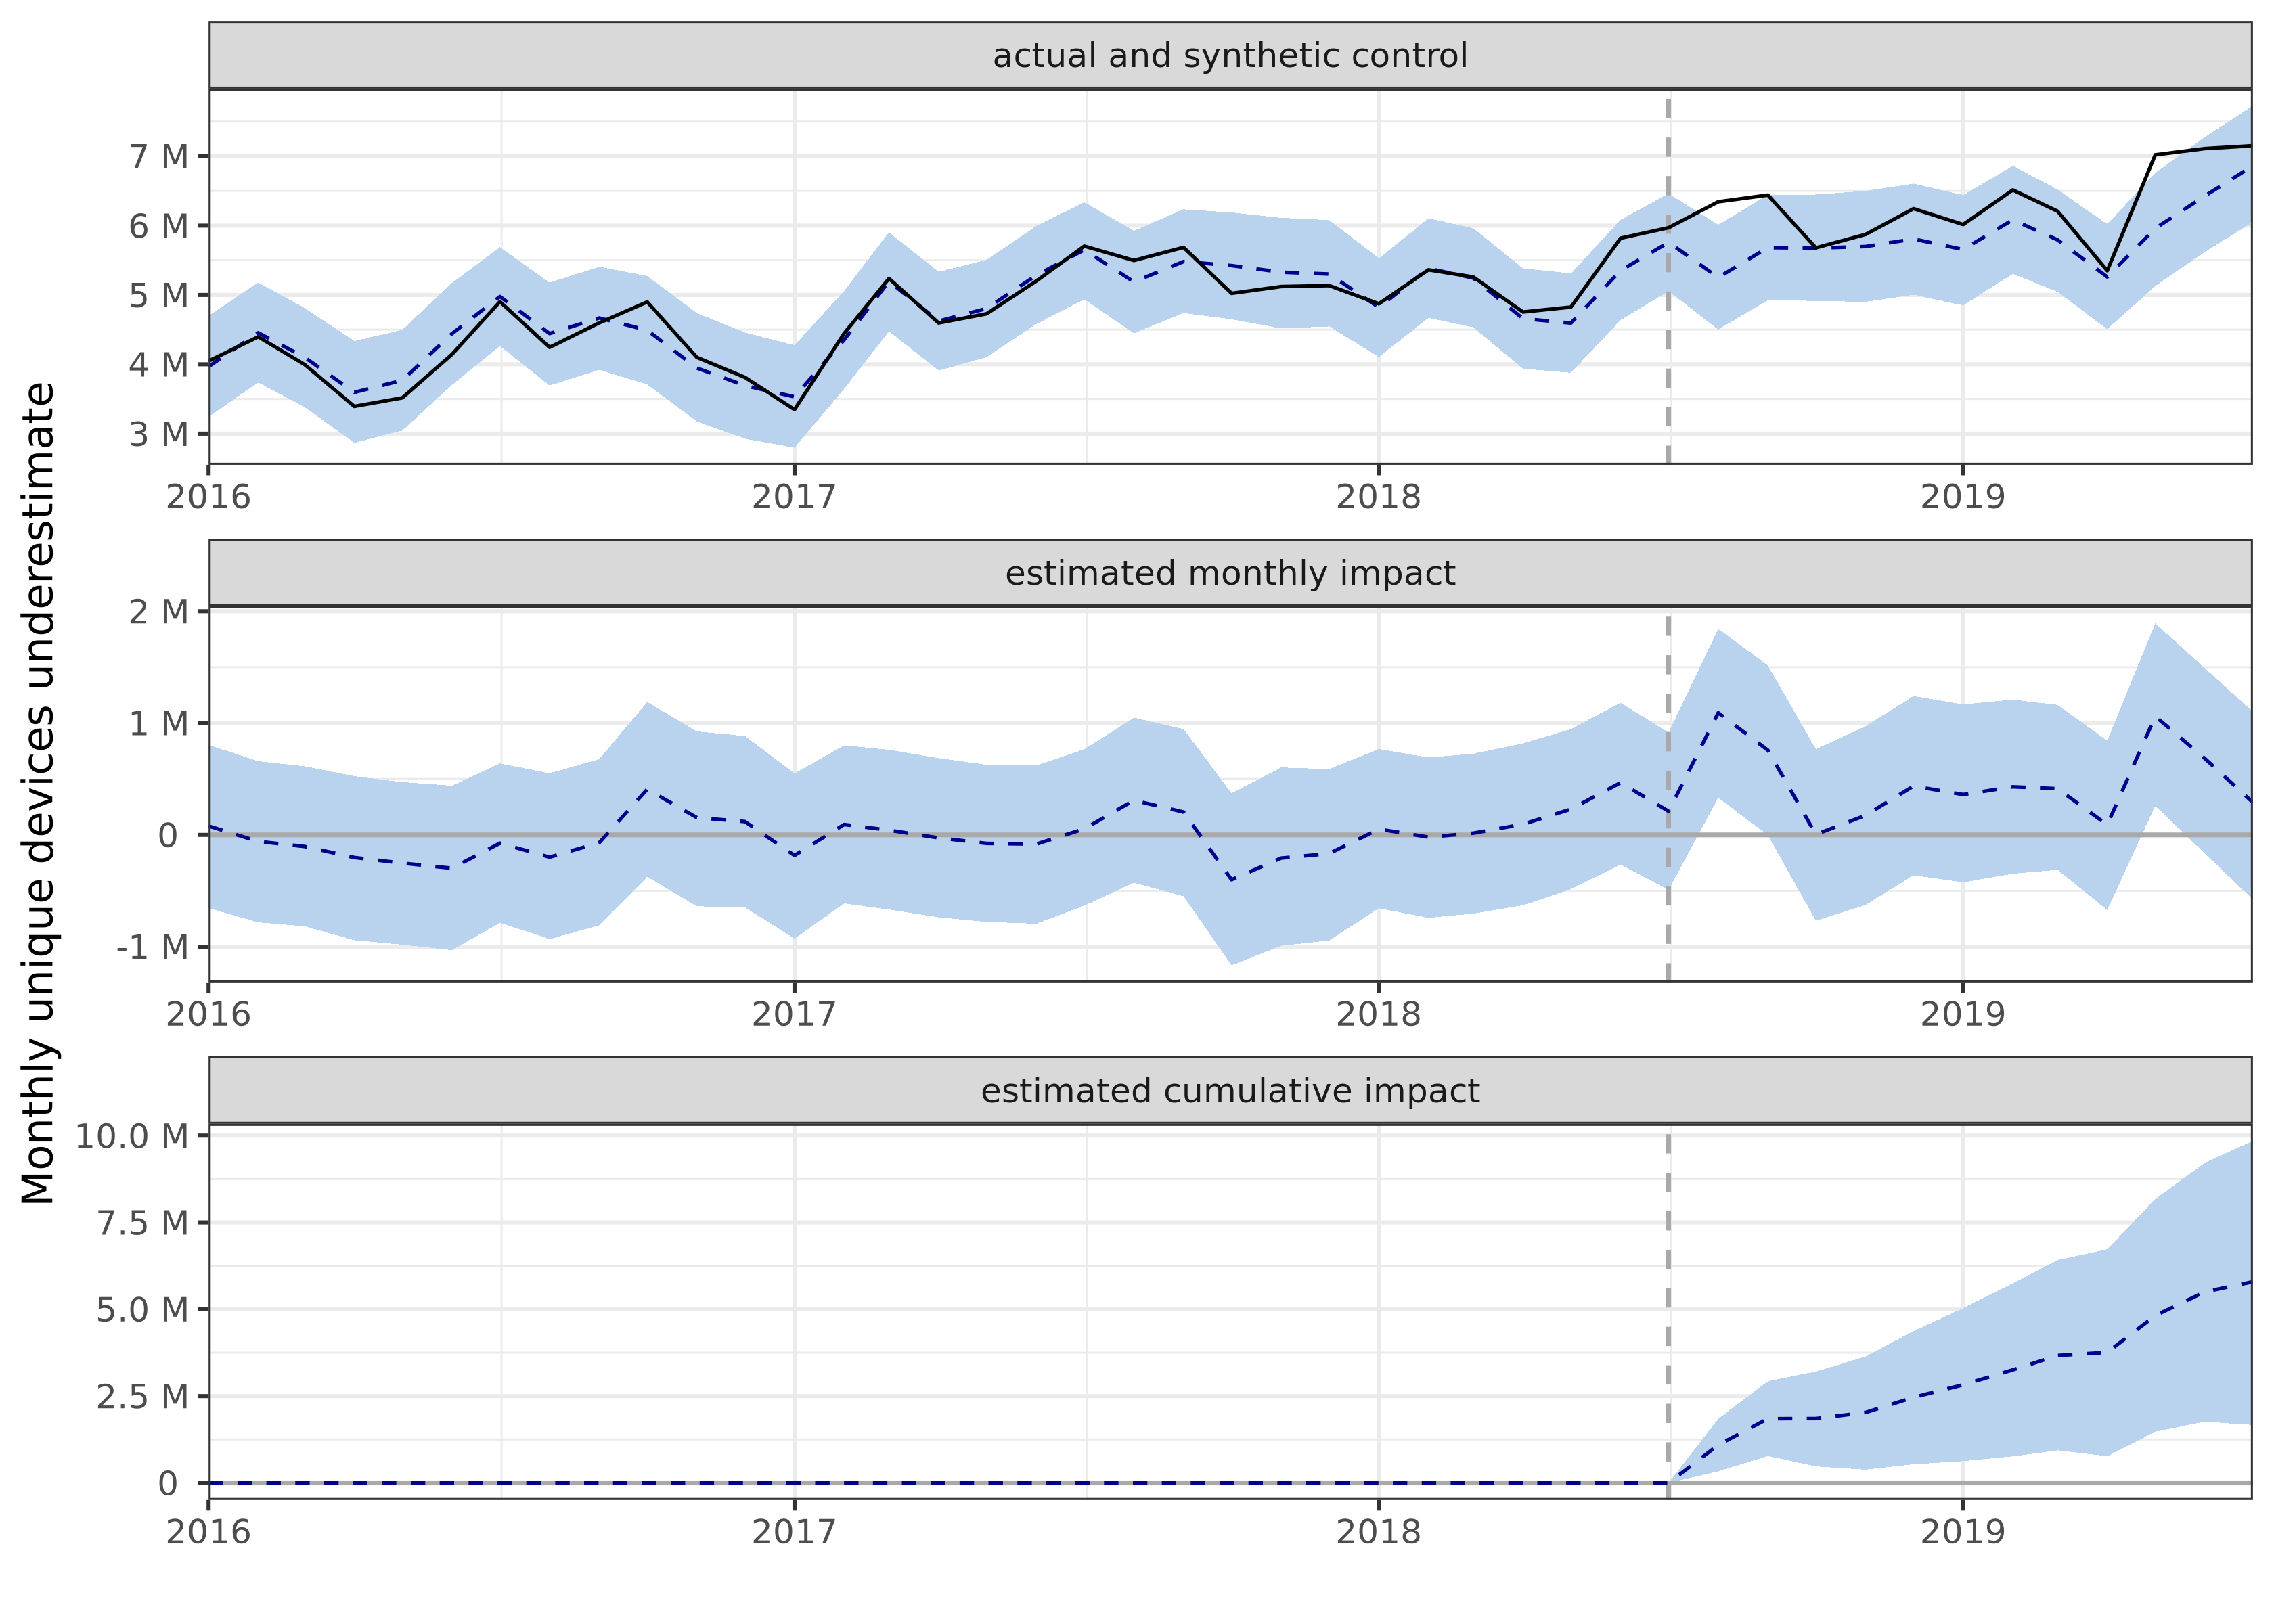

In [90]:
plot_model(c2)

In [92]:
ggsave(
    "eqsin_tranche_2_synthetic_control.png",
    device = "png",
    path = "../figures",
    height = 8.68,
    width = 13.89
)

In [95]:
capture.output(summary(c2), file = "../figures/Singapore_cohort_2_synthetic_control_summary.txt")

summary(c2)

Posterior inference {CausalImpact}

                         Average              Cumulative        
Actual                   6.3e+06              7.6e+07           
Prediction (s.d.)        5.8e+06 (172063)     7.0e+07 (2064751) 
95% CI                   [5.5e+06, 6.2e+06]   [6.6e+07, 7.4e+07]
                                                                
Absolute effect (s.d.)   482648 (172063)      5791779 (2064751) 
95% CI                   [138915, 820573]     [1666975, 9846874]
                                                                
Relative effect (s.d.)   8.3% (3.2%)          8.3% (3.2%)       
95% CI                   [2.2%, 15%]          [2.2%, 15%]       

Posterior tail-area probability p:   0.003
Posterior prob. of a causal effect:  99.6999%

For more details, type: summary(impact, "report")



png 
  2

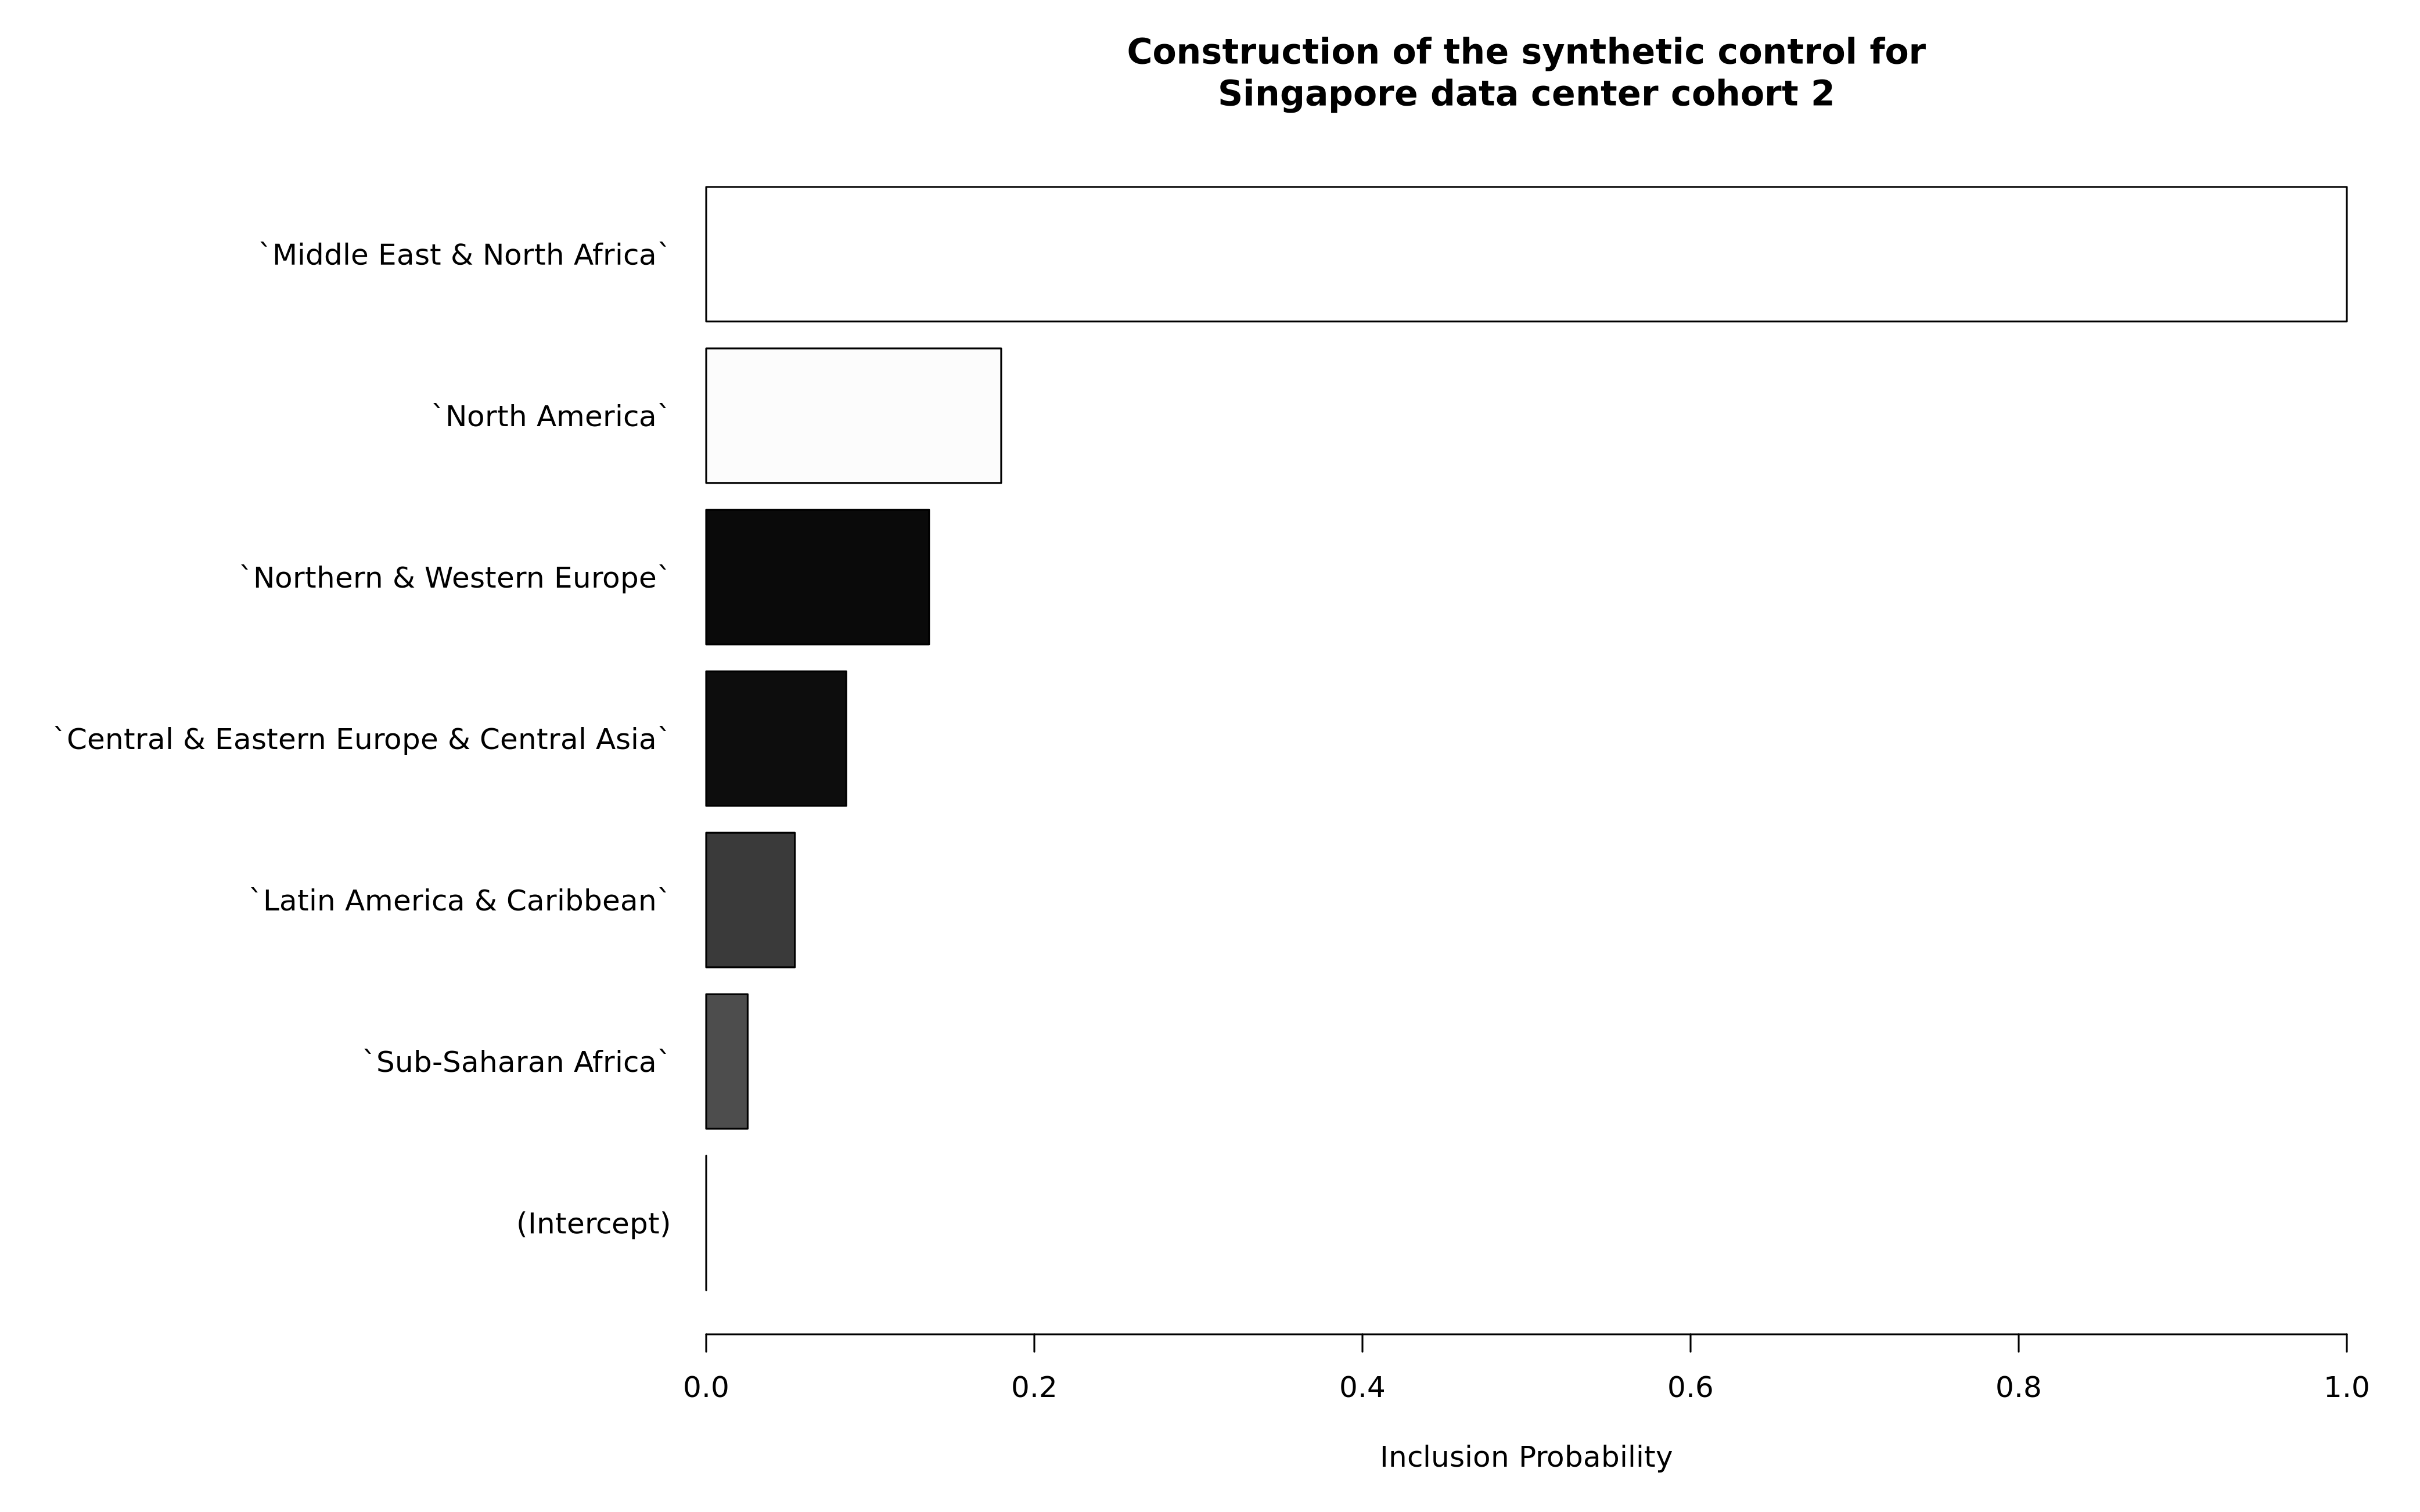

In [96]:
FILE_NAME = "../figures/Singapore_cohort_2_synthetical_control_coefficient_plot.png"

png(
    FILE_NAME,
    res = 300,
    height = 2604,
    width = 4167
)

plot(
    c2$model$bsts.model,
    "coefficients",
    main = "Construction of the synthetic control for\nSingapore data center cohort 2"
)

dev.off()

IRdisplay::display_png(file = FILE_NAME)

## Combined impact

In [97]:
relative_effect <- function(df) {
    df[["summary"]]["Average", "RelEffect"]
}

end = as_date(cohort_1_pre_period[2])
start = end - months(12)

cohort_1_impact <- relative_effect(c1)

cohort_1_size <- cohort_1_uniques |>
    filter(between(time, start, end)) |>
    pull(cohort_1) |>
    mean()

end = as_date(cohort_2_pre_period[2])
start = end - months(12)

cohort_2_impact <- relative_effect(c2)

cohort_2_size <- cohort_2_uniques |>
    filter(between(time, start, end)) |>
    pull(cohort_2) |>
    mean()

It turns out the overall impact is 6.2%, virtually identically to the impact on tranche 1. This is because tranche 1 is much bigger (167 M) than tranche 2 (5.3 M).

In [100]:
total_size <- cohort_1_size + cohort_2_size
combined_impact <-
    cohort_1_impact *
    (cohort_1_size / total_size) +
    cohort_2_impact *
    (cohort_2_size / total_size)

In [106]:
paste(round(combined_impact * 100, 1), "%", sep="")

[1] "6.2%"

In [107]:
format_num <- function(n) {
    scales::label_number(accuracy=0.1, scale_cut=scales::cut_short_scale())(n)
}

format_num(cohort_1_size)

[1] "167.1M"

In [108]:
format_num(cohort_2_size)

[1] "5.3M"